In [1]:
import os
# Must be done before importing numpy, emcee, etc.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import msprime
import phasegen as pg
pg.logger.setLevel("CRITICAL")

In [4]:
Ne1 = 5_000
Ne_f = 10
Ne2 = 15_000
t0 = 50
m = 0.05

In [ ]:
import numba
@numba.njit
def _binld(mts_sites_position, freqs, Y, nbins, minimum, maximum, right_edges_in_bp):
    num_sites = len(mts_sites_position)
    s = Y.shape[0]
    ld = np.zeros(nbins)
    counter = np.zeros(nbins)
    
    for i in range(num_sites):
        px = freqs[i]
        x = (Y[:, i] - 2 * px) / np.sqrt(2 * px * (1 - px))
        for j in range(i + 1, num_sites):
            dist_bp = mts_sites_position[j] - mts_sites_position[i]
            if dist_bp < minimum:
                continue
            if dist_bp > maximum:
                break
            py = freqs[j]
            y = (Y[:, j] - 2 * py) / np.sqrt(2 * py * (1 - py))
            index = 0
            while index < nbins and right_edges_in_bp[index] < dist_bp:
                index += 1
            if index == nbins:
                continue
            xy = np.sum(x * y)
            x2y2 = np.sum(x * x * y * y)
            ld[index] += (xy ** 2 - x2y2) / (s * (s - 1))
            counter[index] += 1
    for k in range(nbins):
        if counter[k] > 0:
            ld[k] /= counter[k]
        else:
            ld[k] = np.nan
    return ld

@numba.njit
def _binld2(sample_sets, mts_sites_position, freqs, Y, nbins, minimum, maximum, right_edges_in_bp):
    num_sites = len(mts_sites_position)
    s = Y.shape[0]
    ld = np.zeros(nbins)
    counter = np.zeros(nbins)
    
    for i in range(num_sites):
        px = freqs[i]
        x = (Y[:, i] - 2 * px) / np.sqrt(2 * px * (1 - px))
        for j in range(i + 1, num_sites):
            dist_bp = mts_sites_position[j] - mts_sites_position[i]
            if dist_bp < minimum:
                continue
            if dist_bp > maximum:
                break
            py = freqs[j]
            y = (Y[:, j] - 2 * py) / np.sqrt(2 * py * (1 - py))
            index = 0
            while index < nbins and right_edges_in_bp[index] < dist_bp:
                index += 1
            if index == nbins:
                continue
            acc = 0.0
            for popi in sample_sets[0]:
                for popj in sample_sets[1]:
                    acc += x[popi]*x[popj]*y[popi]*y[popj]
            ld[index] += acc / (len(sample_sets[0])*len(sample_sets[1]))
            counter[index] += 1
    for k in range(nbins):
        if counter[k] > 0:
            ld[k] /= counter[k]
        else:
            ld[k] = np.nan
    return ld

def binld(mts, Y):
    freqs = allele_frequencies(mts)[:, 0]  # shape: (n_sites,)
    return _binld(
        mts.sites_position,  # 1D array of positions (assumed sorted)
        freqs,
        Y,
        bins['nbins'],
        bins['minimum'],
        bins['maximum'],
        bins['right_edges_in_bp']
    )

def binld2(sts, Y):
    sample_sets = [np.where(sts.individual_populations==0)[0], np.where(sts.individual_populations==1)[0]]
    freqs = allele_frequencies(sts)[:, 0]
    return _binld2(
        sample_sets,
        sts.sites_position,  # 1D array of positions (assumed sorted)
        freqs,
        Y,
        bins['nbins'],
        bins['minimum'],
        bins['maximum'],
        bins['right_edges_in_bp']
    )

def hapne_default(recombination_rate):
    nbins = 25
    left_edges_in_cm = [0.5 + 0.5 * i for i in range(nbins)]
    right_edges_in_cm = [1.0 + 0.5 * i for i in range(nbins)]

    left_edges_in_bp = [x / 100.0 / recombination_rate for x in left_edges_in_cm]
    right_edges_in_bp = [x / 100.0 / recombination_rate for x in right_edges_in_cm]

    minimum = round(left_edges_in_bp[0])
    maximum = round(right_edges_in_bp[-1])

    return {
        "nbins": nbins,
        "left_edges_in_cm": left_edges_in_cm,
        "right_edges_in_cm": right_edges_in_cm,
        "left_edges_in_bp": left_edges_in_bp,
        "right_edges_in_bp": right_edges_in_bp,
        "minimum": minimum,
        "maximum": maximum
    }

bins = hapne_default(1e-8)

In [ ]:
def allele_frequencies(ts, sample_sets=None):
    if sample_sets is None:
       sample_sets = [ts.samples()] 
    n = np.array([len(x) for x in sample_sets])
    def f(x):
       return x / n
    return ts.sample_count_stat(sample_sets, f, len(sample_sets), windows='sites', polarised=True, mode='site', strict=False, span_normalise=False)

def simulator(Ne1, Ne_f, Ne2, t0, m):
    alpha = (np.log(Ne1) - np.log(Ne_f)) / t0
    demography = msprime.Demography()
    demography.add_population(name="p1", initial_size=Ne1, growth_rate = alpha)
    demography.add_population(name="p2", initial_size=Ne2)
    demography.add_population(name="pAnc", initial_size=Ne2)
    demography.add_migration_rate_change(time = 0, rate=m, source="p1", dest="p2")
    demography.add_population_split(derived=["p1", "p2"], ancestral="pAnc", time=t0)
    ts = msprime.sim_ancestry(
        samples={"p1" : 200}, demography=demography,
        recombination_rate=1e-8, sequence_length=1e8,
    )
    mts = msprime.sim_mutations(ts, 5e-9)
    sts = mts.simplify(mts.samples(population_id=0))
    freqs = allele_frequencies(sts)[:, 0]
    mask = np.bitwise_or(freqs<0.25, freqs>0.75)
    sts = sts.delete_sites(np.where(mask)[0]).simplify(filter_sites=True)
    Y = sts.genotype_matrix().T
    Y = Y[::2, ] + Y[1::2, ]
    return binld(sts, Y)

In [ ]:
import multiprocess

def run_simulation(_):
    return simulator(Ne1, Ne_f, Ne2, t0, m)

with multiprocess.Pool(8) as pool:
    observed = pool.map(run_simulation, range(8))

In [6]:
observed_p1 = np.array(observed)
observed_p1

array([[0.00773138, 0.00556084, 0.00423309, 0.00338528, 0.00275525,
        0.00233092, 0.0019113 , 0.00168695, 0.00147708, 0.0013454 ,
        0.00118923, 0.0010364 , 0.00096163, 0.00093679, 0.00084498,
        0.00078989, 0.00071023, 0.00065048, 0.00063017, 0.00061313,
        0.00056659, 0.00049631, 0.00044499, 0.00046582, 0.00047664],
       [0.00668374, 0.00480392, 0.00377931, 0.00312283, 0.00255978,
        0.00217791, 0.00193143, 0.00163962, 0.00136137, 0.00120868,
        0.00109648, 0.00091577, 0.0008699 , 0.00083447, 0.00078707,
        0.00065658, 0.00069946, 0.00065815, 0.0005435 , 0.00054055,
        0.00054326, 0.00049328, 0.00046089, 0.00048288, 0.00043936],
       [0.00789003, 0.00582339, 0.00450073, 0.00357608, 0.00293229,
        0.00240978, 0.00212409, 0.00180977, 0.00158802, 0.00138658,
        0.00127683, 0.00111827, 0.00103238, 0.00098906, 0.00085856,
        0.00084183, 0.00078802, 0.00075908, 0.00074241, 0.00066612,
        0.00061077, 0.00057566, 0.00048554, 0.

In [8]:
n = 50
x_leggauss, w_leggauss = np.polynomial.legendre.leggauss(n)
def gauss(a, b):
    x, w = x_leggauss.copy(), w_leggauss.copy() #np.polynomial.legendre.leggauss(n)
    w = (b - a) / 2 * w
    x = (b - a) / 2 * x + (a + b) / 2
    return x, w

u_i = np.array(bins['left_edges_in_cm']) / 100
u_j = np.array(bins['right_edges_in_cm']) / 100

u_points = np.array([gauss(a, b)[0] for (a, b) in zip(u_i, u_j)])
u_weights = np.array([gauss(a, b)[1] / (b - a) for (a, b) in zip(u_i, u_j)])

def correct_r2(mu, sample_size):
    S = sample_size * 2  # diploid assumption
    beta = 1 / (S - 1) ** 2
    alpha = ((S**2 - S + 2) ** 2) / ((S**2 - 3 * S + 2) ** 2)
    return (alpha - beta) * mu + 4 * beta
    
def expected_mean(theta):
    # Get parameters
    
    Ne1, Ne_f, Ne2, t0, m = theta
    G = 1.0
    # Pre-compute quadrature points and weights
    times1, w1 = gauss(0, t0)
    times3, w3 = gauss(t0, 5000)
    # Combine all times and weights
    all_times = np.concatenate([times1, times3])
    all_weights = np.concatenate([w1, w3])
    # Define demography once
    alpha = (np.log(Ne1) - np.log(Ne_f)) / t0
    d = pg.Demography(
        events=[
            pg.DiscretizedRateChange(
                        trajectory=lambda t: 2*Ne1*np.exp(-alpha*t),
                        pop='pop_0',
                        start_time=0,
                        end_time=t0,
                        step_size=5
                    ),
            pg.PopSizeChange(pop='pop_1', time=0, size=Ne2*2),
            pg.MigrationRateChange(source='pop_0', dest='pop_1', time=0, rate=m),
            pg.PopulationSplit(
                        derived='pop_1',
                        ancestral='pop_0',
                        time=t0
                    )
        ]
    )
    # Pre-compute coalescent objects
    coal1 = pg.Coalescent(n={'pop_0': 2, 'pop_1': 0}, demography=d)
    cdf1 = coal1.tree_height.cdf(all_times)
    times_2d = all_times[:, np.newaxis]  # Shape: (n_times, 1)
    bins_2d = u_points.flatten()[np.newaxis, :]  # Shape: (1, n_bins)
    weights_2d = all_weights[:, np.newaxis]  # Shape: (n_times, 1)
    # Compute the integrand for all combinations at once
    # Shape: (n_times, n_bins)
    integrand_base = 2*bins_2d*np.exp(-2*times_2d*bins_2d)
    # Compute results using matrix multiplication
    r2_flat = np.sum(integrand_base * cdf1[:, np.newaxis] * weights_2d, axis=0)
    r2_matrix = r2_flat.reshape(u_points.shape)
    return correct_r2(np.sum(r2_matrix * u_weights, axis=1), 200)

<Axes: >

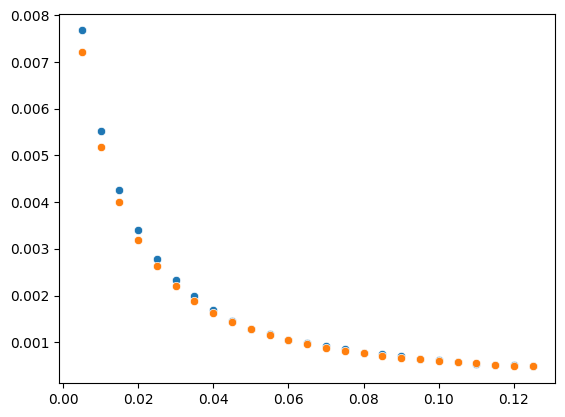

In [11]:
import seaborn as sns

sns.scatterplot(
    x = u_i, 
    y = observed_p1.mean(axis=0)
)

sns.scatterplot(
    x = u_i, 
    y = expected_mean([Ne1, Ne_f, Ne2, t0, m])
)

In [23]:
def worker(x):
    mu1 = expected_mean([Ne1, Ne_f, Ne2, t0, x])
    sigma1 = observed_p1.std(axis=0)
    ll1 = -0.5 * np.sum(
        ((observed_p1 - mu1)**2) / (sigma1**2) + np.log(2 * np.pi * sigma1**2)
    )
    return ll1
candidates = np.linspace(m - 0.015, m + 0.015, 100)
vals =  np.array([worker(x).sum() for x in candidates])

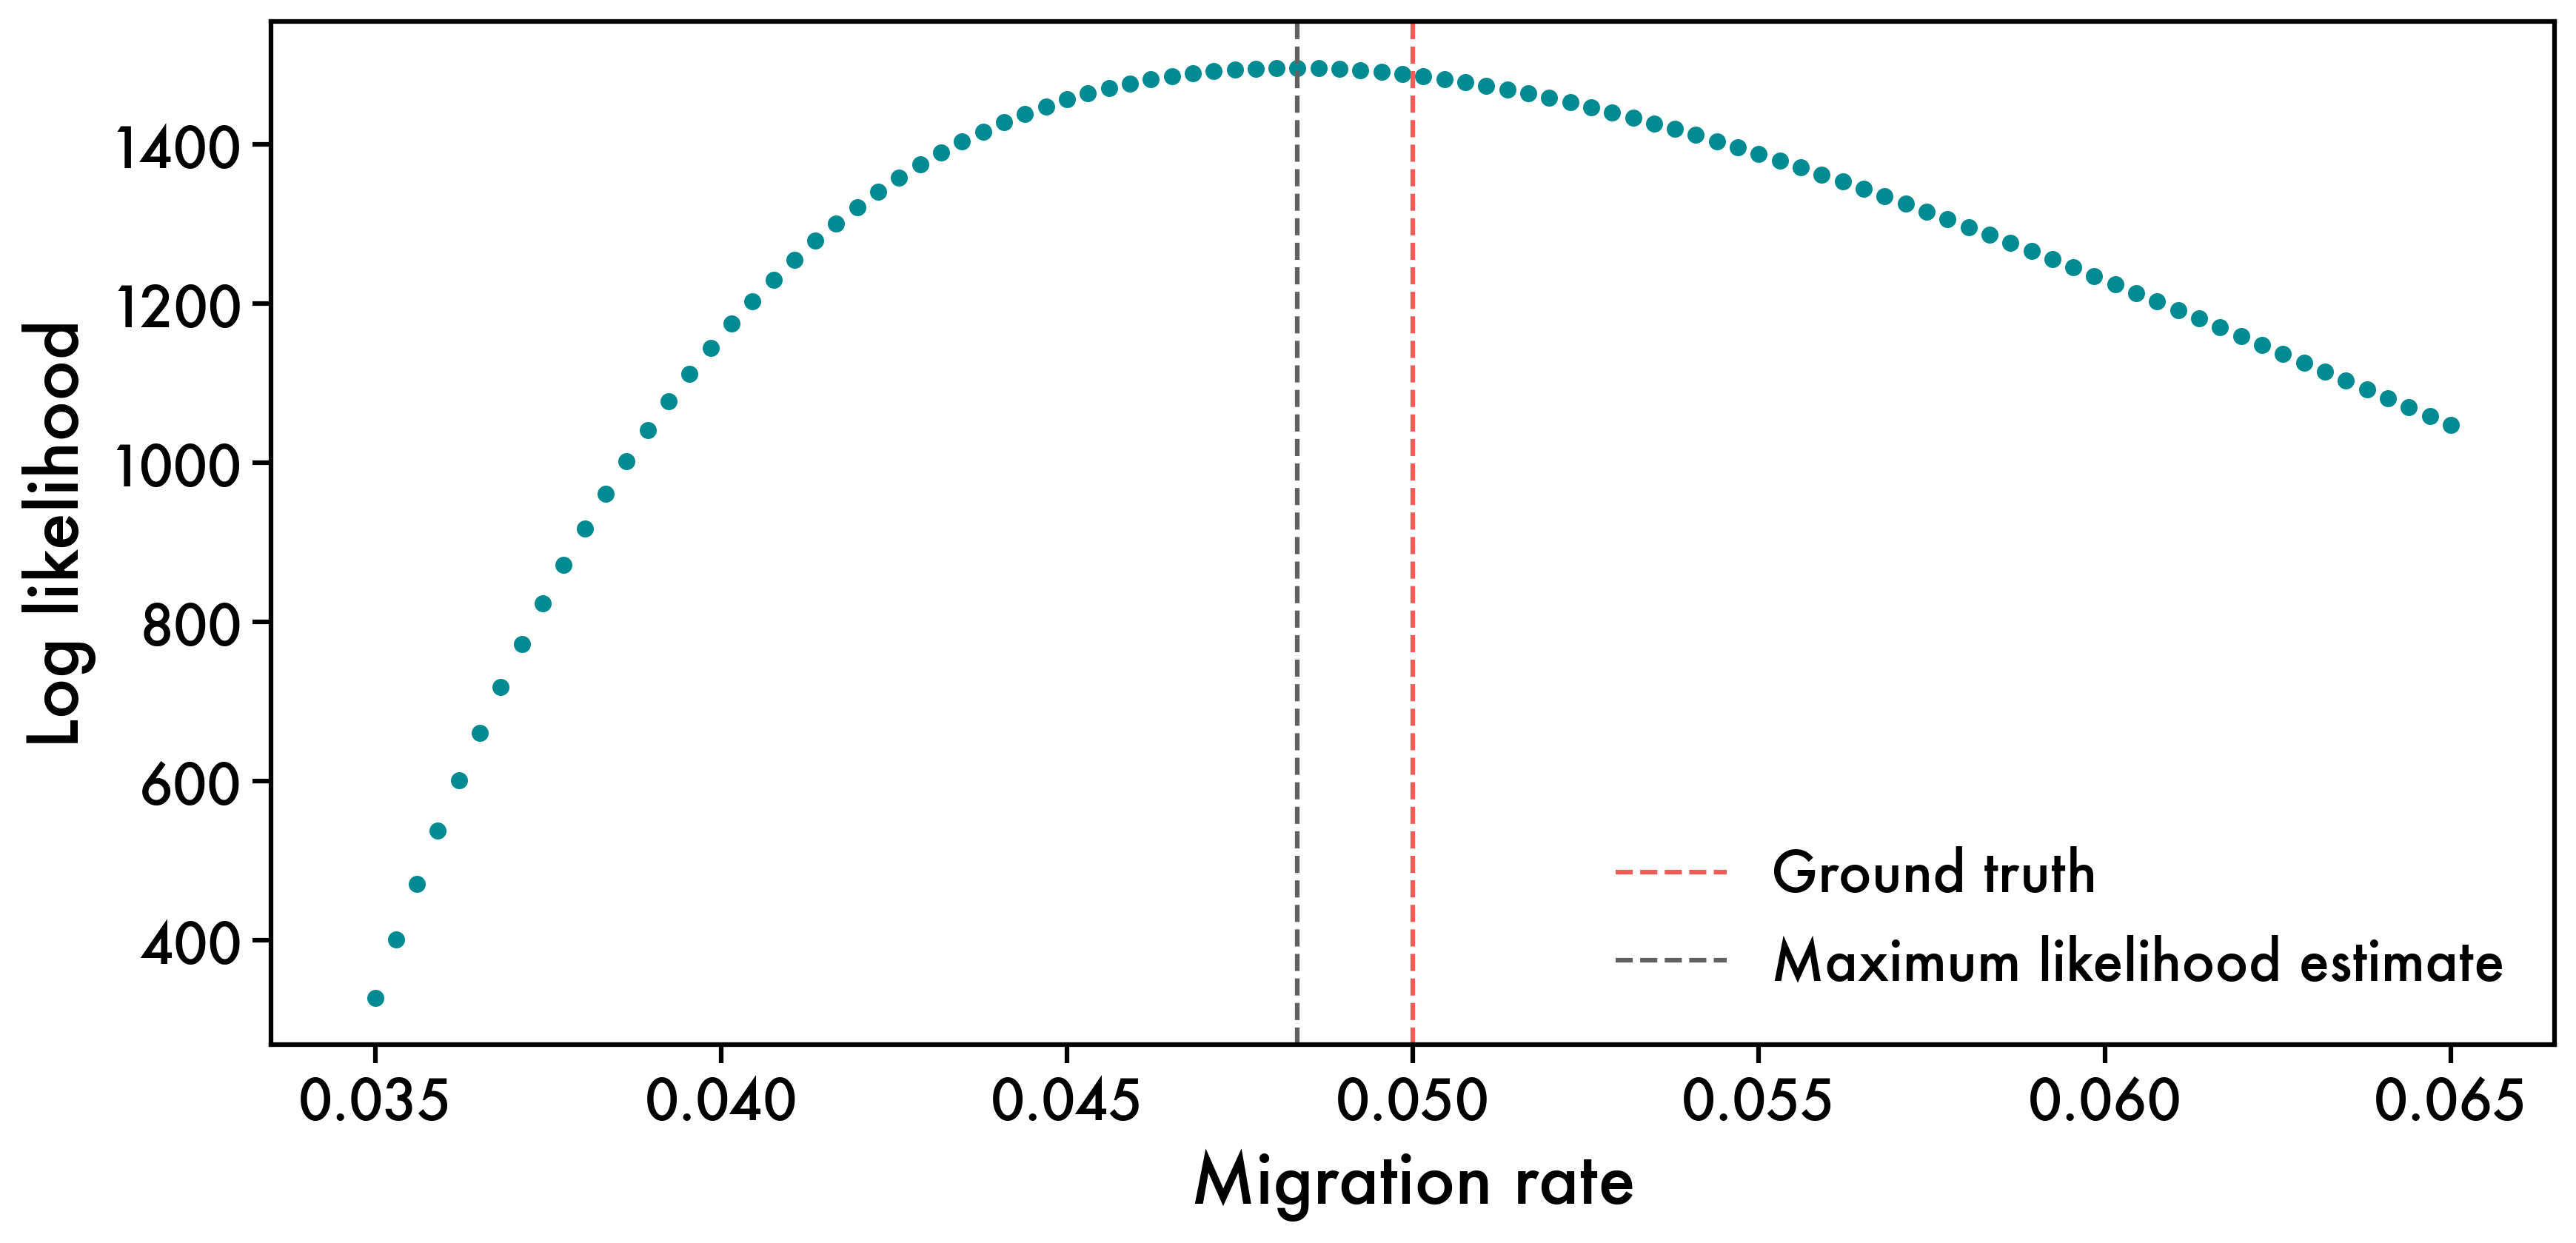

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import arviz as az
import numpy as np
from scipy.stats import gaussian_kde

# Poster-style settings (as before)
mpl.rcParams.update({
    "font.family": "Futura",
    "font.size": 20,
    "axes.labelsize": 22,
    "axes.titlesize": 22,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


colors = ["#008b92", "#f15c58", "#48cdef", "#98d81a", "#997ee5", 
          "#f5dc9d", "#c90a4e", "#145393", "#323232", "#616161"]

fig, ax = plt.subplots(figsize=(12, 6))

ax.axvline(x=m, color=colors[1], linestyle='--', label="Ground truth")
ax.axvline(x=candidates[vals.argmax()], color=colors[9], linestyle='--', label="Maximum likelihood estimate")
sns.scatterplot(x=candidates, y=vals, ax=ax, color=colors[0])

ax.set_xlabel("Migration rate")
ax.set_ylabel("Log likelihood")
ax.legend(frameon=False, loc="best")

plt.tight_layout()
fig.savefig("likelihood_curve.pdf", bbox_inches="tight", pad_inches=0)
plt.show()
